In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/DLS_data/prepared_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [ ]:
train_sharp_images = np.load('/content/sample_data/prepared_data/train_sharp_images.npy', mmap_mode='r')
train_blur_images = np.load('/content/sample_data/prepared_data/train_blur_images.npy', mmap_mode='r')
test_sharp_images = np.load('/content/sample_data/prepared_data/test_sharp_images.npy', mmap_mode='r')
test_blur_images = np.load('/content/sample_data/prepared_data/test_blur_images.npy', mmap_mode='r')

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_blur, data_sharp):
        self.data_blur = data_blur
        self.data_sharp = data_sharp

    def __len__(self):
        return len(self.data_blur)

    def __getitem__(self, idx):
        X = self.data_sharp[idx]
        y = self.data_blur[idx]

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()

        return X, y

In [ ]:
batch_size = 4
test_dataset = ImageDataset(test_blur_images, test_sharp_images)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_dataset = ImageDataset(test_blur_images, test_sharp_images)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

<ipython-input-5-0cf1156fbe48>:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  X = torch.from_numpy(X).float()


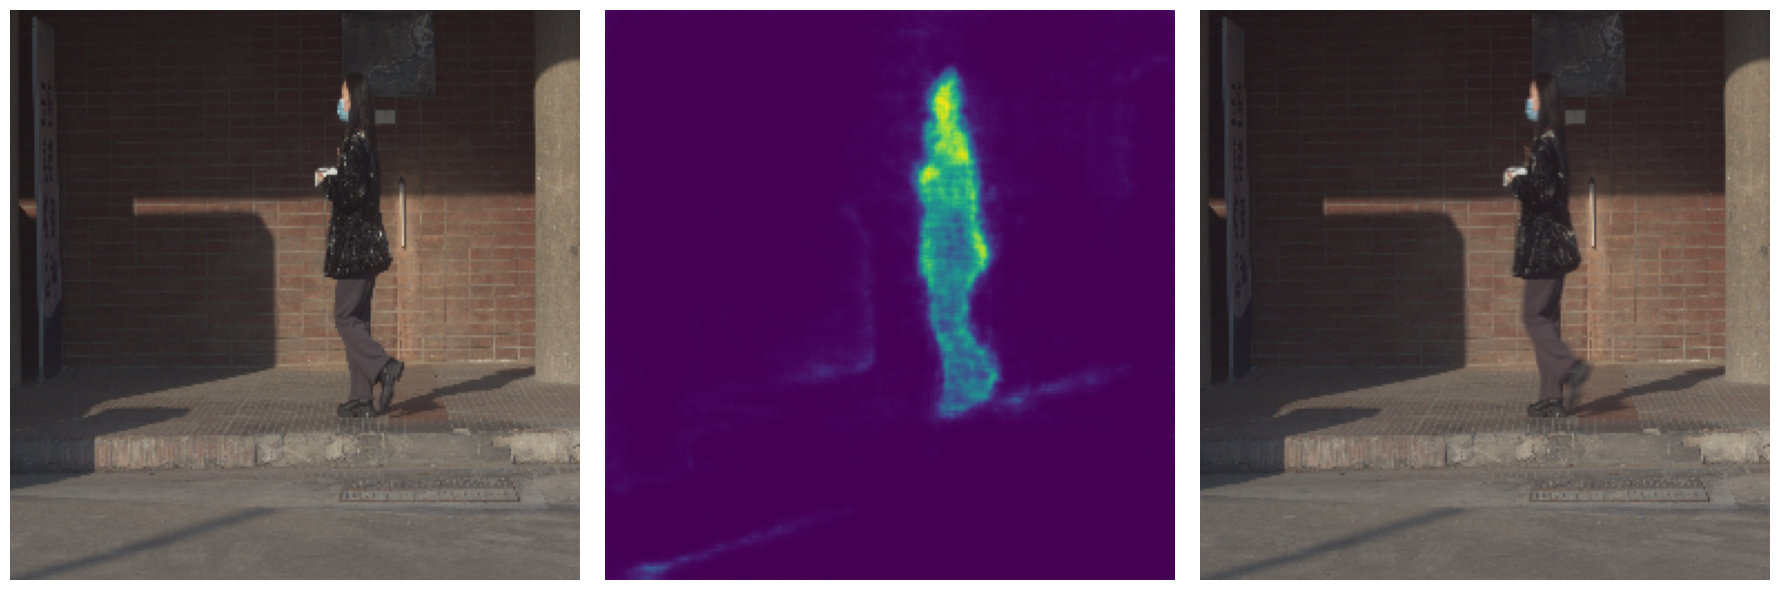

In [ ]:
X_batch, Y_batch = next(iter(train_dataloader))
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(X_batch[0][0:3].permute(1, 2, 0)) # sharp image
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(X_batch[0][3]) # possible motion blur location
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(Y_batch[0].permute(1, 2, 0)) # ground truth blur image
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat([x, skip_input], 1)
        return x

class UNetGenerator(nn.Module):
    def __init__(self, input_channels=4, output_channels=3):
        super().__init__()

        self.down1 = UNetDown(input_channels, 192, normalize=False)
        self.down2 = UNetDown(192, 384)
        self.down3 = UNetDown(384, 768)
        self.down4 = UNetDown(768, 1536, dropout=0.5)
        self.down5 = UNetDown(1536, 1536, dropout=0.5)
        self.down6 = UNetDown(1536, 1536, dropout=0.5)
        self.down7 = UNetDown(1536, 1536, dropout=0.5)
        self.down8 = UNetDown(1536, 1536, normalize=False, dropout=0.5)

        self.up1 = UNetUp(1536, 1536, dropout=0.5)
        self.up2 = UNetUp(3072, 1536, dropout=0.5)
        self.up3 = UNetUp(3072, 1536, dropout=0.5)
        self.up4 = UNetUp(3072, 1536, dropout=0.5)
        self.up5 = UNetUp(3072, 768)
        self.up6 = UNetUp(1536, 384)
        self.up7 = UNetUp(768, 192)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(384, output_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, input_channels=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 288, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(288, 576, 4, 2, 1),
            nn.BatchNorm2d(576),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(576, 1152, 4, 2, 1),
            nn.BatchNorm2d(1152),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1152, 1536, 4, 1, 1),
            nn.BatchNorm2d(1536),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1536, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        x = x[:, :3, :, :]
        x = torch.cat([x, y], 1)
        return self.model(x)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0.0)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGenerator(input_channels=4, output_channels=3).to(device)
discriminator = Discriminator(input_channels=6).to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
lambda_l1 = 100

# Training loop with test evaluation
def train_model(train_loader, test_loader, epochs):
    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()
        train_d_loss, train_g_loss = 0.0, 0.0

        for i, (X_batch, Y_batch) in enumerate(train_loader):
            X = X_batch.to(device)
            Y = Y_batch.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            real_pred = discriminator(X, Y)
            real_loss = criterion_GAN(real_pred, torch.ones_like(real_pred))

            fake_Y = generator(X).detach()
            fake_pred = discriminator(X, fake_Y)
            fake_loss = criterion_GAN(fake_pred, torch.zeros_like(fake_pred))

            d_loss = (real_loss + fake_loss) * 0.5
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            gen_Y = generator(X)
            gen_pred = discriminator(X, gen_Y)
            gan_loss = criterion_GAN(gen_pred, torch.ones_like(gen_pred))
            l1_loss = criterion_L1(gen_Y, Y)
            g_loss = gan_loss + lambda_l1 * l1_loss

            g_loss.backward()
            optimizer_G.step()

            # Accumulate losses for logging
            train_d_loss += d_loss.item()
            train_g_loss += g_loss.item()

            # Log progress
            if i % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {i}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        train_d_loss /= len(train_loader)
        train_g_loss /= len(train_loader)

        # Test phase
        generator.eval()
        discriminator.eval()
        test_d_loss, test_g_loss = 0.0, 0.0

        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                X = X_batch.to(device)
                Y = Y_batch.to(device)

                # Discriminator evaluation
                real_pred = discriminator(X, Y)
                real_loss = criterion_GAN(real_pred, torch.ones_like(real_pred))

                fake_Y = generator(X)
                fake_pred = discriminator(X, fake_Y)
                fake_loss = criterion_GAN(fake_pred, torch.zeros_like(fake_pred))

                d_loss = (real_loss + fake_loss) * 0.5

                # Generator evaluation
                gen_pred = discriminator(X, fake_Y)
                gan_loss = criterion_GAN(gen_pred, torch.ones_like(gen_pred))
                l1_loss = criterion_L1(fake_Y, Y)
                g_loss = gan_loss + lambda_l1 * l1_loss

                test_d_loss += d_loss.item()
                test_g_loss += g_loss.item()

        test_d_loss /= len(test_loader)
        test_g_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{epochs} Summary:")
        print(f"Train D Loss: {train_d_loss:.4f}, Train G Loss: {train_g_loss:.4f}")
        print(f"Test D Loss: {test_d_loss:.4f}, Test G Loss: {test_g_loss:.4f}")

In [ ]:
train_model(train_dataloader, test_dataloader, epochs=15)

Epoch 1/15, Batch 0, D Loss: 0.7418, G Loss: 6.1686
Epoch 1/15, Batch 50, D Loss: 0.7005, G Loss: 5.7797
Epoch 1/15, Batch 100, D Loss: 0.8559, G Loss: 4.7957
Epoch 1/15, Batch 150, D Loss: 0.5292, G Loss: 5.0623
Epoch 1/15 Summary:
Train D Loss: 0.7077, Train G Loss: 5.3981
Test D Loss: 0.8875, Test G Loss: 5.8013
Epoch 2/15, Batch 0, D Loss: 0.5057, G Loss: 5.4439
Epoch 2/15, Batch 50, D Loss: 1.1383, G Loss: 3.9455
Epoch 2/15, Batch 100, D Loss: 0.7346, G Loss: 3.3901
Epoch 2/15, Batch 150, D Loss: 0.6775, G Loss: 3.3012
Epoch 2/15 Summary:
Train D Loss: 0.6741, Train G Loss: 4.0823
Test D Loss: 0.7896, Test G Loss: 4.0808
Epoch 3/15, Batch 0, D Loss: 0.7201, G Loss: 3.1992
Epoch 3/15, Batch 50, D Loss: 0.6902, G Loss: 3.4618
Epoch 3/15, Batch 100, D Loss: 0.6459, G Loss: 3.4036
Epoch 3/15, Batch 150, D Loss: 0.7372, G Loss: 3.5286
Epoch 3/15 Summary:
Train D Loss: 0.7129, Train G Loss: 3.2154
Test D Loss: 1.3748, Test G Loss: 4.7253
Epoch 4/15, Batch 0, D Loss: 0.6237, G Loss: 3.21

In [ ]:
torch.save(generator, 'generator_v2.pth')

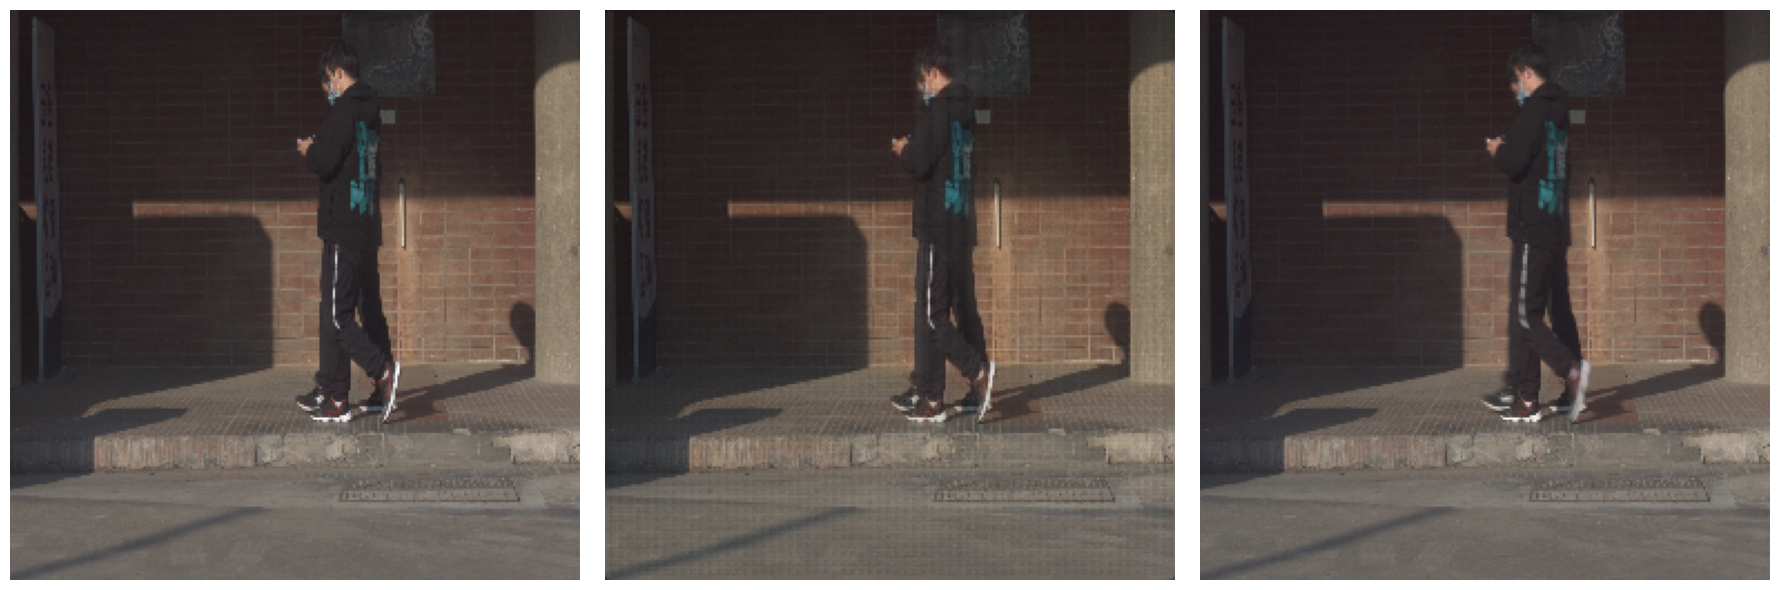

In [ ]:
X_batch, Y_batch = next(iter(test_dataloader))
X = X_batch.to(device)
fake_Y = generator(X)
fake_Y = fake_Y.detach().cpu()
X_batch = X_batch.detach().cpu()
Y_batch = Y_batch.detach().cpu()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(X_batch[0][0:3].permute(1, 2, 0)) # sharp image
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(fake_Y[0].permute(1, 2, 0)) # generated blur image
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(Y_batch[0].permute(1, 2, 0)) # ground truth blur image
plt.axis('off')
plt.tight_layout()
plt.show()